In [78]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import linalg
from scipy.spatial import cKDTree
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d

from astropy.io import fits
from astropy.table import Table
from astropy.table import vstack
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.coordinates import concatenate
from astropy import units as u

from matplotlib.patches import Ellipse
from scipy.spatial.transform import Rotation

import treecorr
import random

import torch
from torch.distributions import Uniform

from sbi.utils import BoxUniform
from sbi.analysis import pairplot
from sbi.inference import NPE, SNPE, simulate_for_sbi, infer
from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
    prepare_for_sbi
)

from scipy.spatial.distance import pdist, squareform
from sklearn.neighbors import BallTree

import math
import os

import corner
from scipy.ndimage import gaussian_filter
import time, glob

### Cosmological parameters

In [4]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3) ; h=0.7

### Function required for further work

In [79]:
# Computing absolute ellipticity 
def abs_e(e1,e2):
    return np.sqrt(e1*e1+e2*e2)

# Computing small and large axis of the ellipse
def a_b(e1,e2):
    e = abs_e(e1,e2)
    return 1+e,1-e  

# Computing complex elipticity
def e_complex(a,b,r):
    abs_e = (1-(b/a)) / (1+(b/a))
    e1 = abs_e*np.cos(2*r)
    e2 = abs_e*np.sin(2*r)
    return e1, e2

# Format ellipsoid parameters to match Abacus (eigenvectors and values must be in order of least to greatest)
def format_ellipsoid(eigenvectors, eigenvalues, position = np.asarray([0,0,0])):
    el = Table()
    el['sigman_eigenvecsMin_L2com'] = eigenvectors[0]
    el['sigman_eigenvecsMid_L2com'] = eigenvectors[1]
    el['sigman_eigenvecsMaj_L2com'] = eigenvectors[2]
    
    el['sigman_L2com'] = np.sqrt(eigenvalues)
    
    return el

### Abacus halos (z=0.575)

Snapshot z=0.575, box of size 2 Gpc, base_c000_ph000

In [80]:
# Halo catalog 
halos_table = Table.read('/Users/antonincorinaldi/Documents/stage césure/code/projet_stage/sbi/model_2/Abacus_halos_z0.575.fits')


# Selecting a certain number of halo
nb_halos=200_000
halos_table = halos_table[:nb_halos]


# Positions in 3D
x = halos_table['x_L2com'][:,0] * u.Mpc
y = halos_table['x_L2com'][:,1] * u.Mpc
z = halos_table['x_L2com'][:,2] * u.Mpc

x_val = x.value ; y_val = y.value ; z_val = z.value



# Computation of the redshift
d_c = np.sqrt(x**2 + y**2 + z**2)
redshifts = np.array([z_at_value(cosmo.comoving_distance, d) for d in d_c])
halos_table['Z'] = redshifts


# Comoving coordinates
chi = cosmo.comoving_distance(redshifts).value

### Model : population of halos by galaxies

In [67]:
# Function to generate a population of galaxies that live into Abacus halos
# Returns the eigenvectors inherited from the host-halos and the eigenvalues modified by the tau_B and tau_C parameters

def population_3D (mu_tau_B, mu_tau_C, sigma_tau_B, sigma_tau_C, r_tau, el=halos_table, nb_halos=nb_halos) : 

    halos_table2 = el.copy()

    # Eigenvalues of the halos
    eigenvalues_orig = np.array(halos_table2['sigman_L2com'])

    valid_eigenvalues = []

    while len(valid_eigenvalues) < nb_halos:
        # Gaussian draw for tau_B, tau_C
        taus = np.random.multivariate_normal(mean=[mu_tau_B, mu_tau_C], cov=[[sigma_tau_B**2, r_tau * sigma_tau_B * sigma_tau_C],[r_tau * sigma_tau_B * sigma_tau_C, sigma_tau_C**2]],size=nb_halos)
    
        tau_B2 = np.clip(taus[:, 0], 0, 1)
        tau_C2 = np.clip(taus[:, 1], 0, 1)

        eigenvalues = eigenvalues_orig.copy()

        # Multiplying halos axis by tau_B and tau_C
        eigenvalues[:, 1] *= tau_B2
        eigenvalues[:, 2] *= tau_C2

        Ag, Bg, Cg = eigenvalues[:, 0], eigenvalues[:, 1], eigenvalues[:, 2]
        mask = (Bg / Ag <= 1) & (Cg / Ag <= 1) & (Bg >= Cg) & (Bg > 0) & (Cg > 0)
        filtered = eigenvalues[mask]

        to_add = min(nb_halos - len(valid_eigenvalues), filtered.shape[0])
        valid_eigenvalues.extend(filtered[:to_add])


    eigenvalues = np.array(valid_eigenvalues) 
   
    
    eigenvecs_Min = halos_table2['sigman_eigenvecsMin_L2com'][:len(eigenvalues)]
    eigenvecs_Mid = halos_table2['sigman_eigenvecsMid_L2com'][:len(eigenvalues)]
    eigenvecs_Max = halos_table2['sigman_eigenvecsMaj_L2com'][:len(eigenvalues)]

    eigenvectors = np.stack((eigenvecs_Min, eigenvecs_Mid, eigenvecs_Max), axis=1)

    ellipses = np.array([format_ellipsoid(eigenvectors[i, :, :], eigenvalues[i, :]) for i in range(nb_halos)])
    ellipses = np.array(ellipses)

    evcl = np.array([ellipses['sigman_eigenvecsMaj_L2com'], ellipses['sigman_eigenvecsMid_L2com'], ellipses['sigman_eigenvecsMin_L2com']])
    evcl=np.transpose(evcl, (1, 0, 2))
    evls = ellipses['sigman_L2com']**2 

    
    return evcl, evls

### Projection of 3D halo shapes in 2D

In [81]:
# Function to compute the projected ellipticities of the halos after projection of their 3D shape


def simulator(theta, 
                el=halos_table,
                nb_halos=nb_halos, 
                p_axis='y', # The direction of projection (here 'y' denotes by convention the direction of the line-of-sight)
                e_bins=np.linspace(0,1,100) # The number of bins for the histogram of e_counts (output)
               ):

    tau_B, tau_C, sigma_tau_B, sigma_tau_C, r_tau = theta

    evcl, evls = population_3D (tau_B, tau_C, sigma_tau_B, sigma_tau_C, r_tau, el, nb_halos)
    

    # Projection 3D => 2D
    if p_axis=='x': # Projection perpendicular to the LOS
        K = np.sum(evcl[:,:,0][:,:,None]*(evcl/evls[:,None]), axis=1)
        r = evcl[:,:,2] - evcl[:,:,0] * K[:,2][:,None] / K[:,0][:,None]
        s = evcl[:,:,1] - evcl[:,:,0] * K[:,1][:,None] / K[:,0][:,None] 

    if p_axis=='y': # Projection along the LOS
        K = np.sum(evcl[:,:,1][:,:,None] * (evcl/evls[:,None]), axis=1)
        r = evcl[:,:,0] - evcl[:,:,1] * K[:,0][:,None] / K[:,1][:,None]
        s = evcl[:,:,2] - evcl[:,:,1] * K[:,2][:,None] / K[:,1][:,None]


    # Coefficients A,B,C (eq 23 of (2))
    A1 = np.sum(r**2 / evls, axis=1)
    B1 = np.sum(2*r*s / evls, axis=1)
    C1 = np.sum(s**2 / evls, axis=1)


    # Axis a_p,b_p and orientation angle r_p of the projected galaxy
    r_p = np.pi / 2 + np.arctan2(B1,A1-C1)/2
    a_p = 1/np.sqrt((A1+C1)/2 + (A1-C1)/(2*np.cos(2*r_p)))
    b_p = 1/np.sqrt(A1+C1-(1/a_p**2))


    # Projected ellipticity
    e1, e2 = e_complex(a_p, b_p, r_p) ; e = [e1,e2] ; e=np.array(e)

    
    return e1, e2



e1_halos, e2_halos = simulator([1,1,0,0,0], el=halos_table)


halos_table['e1']= e1_halos ; halos_table['e2']= e2_halos

### Computing halo intrinsic alignments (using TreeCorr https://ui.adsabs.harvard.edu/abs/2015ascl.soft08007J/abstract)

1) Of the Abacus halos

In [82]:
# Function that computes the 2-point correlation function xi_g+ and xi_gx for the Abacus halos projected shapes and the associated variances (using Jackknife)

def compute_halo_intrinsic_alignments (x_val, y_val, z_val, e1, e2, nrp=25, npi=50, npatch=20):
    
    # Catalog of halos
    halo_shapes = treecorr.Catalog(x=x_val, y=y_val, z=z_val, g1=e1, g2=e2, npatch=npatch)

    # Line-of-sight direction
    pi = np.linspace(-60, 60, npi)

    xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
    var = [] ; var = list(var) ; rp = [] ; rp = list(rp)

    for i in np.arange(0, npi-1):

        ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = 0.1,
                                max_sep = 60.,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type='Linear',
                                bin_slop=0.1,
                                angle_slop=0.1,
                                var_method='jackknife',
                                cross_patch_weight='simple')
        ng.process(halo_shapes, halo_shapes, metric ='Rperp')

        xi_p, xi_c, var2 = ng.calculateXi(rg=None) ; r=ng.meanr

        xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r)

    xi_gp_halos_tc=np.array(xi_gp) ; xi_gc_halos_tc=np.array(xi_gc) ; var_halos_tc = np.array(var) ; r_halos_tc = np.array(rp)

    return xi_gp_halos_tc, xi_gc_halos_tc, var_halos_tc, r_halos_tc

In [83]:
xi_gp_halos_tc, xi_gc_halos_tc, var_halos_tc, r_halos_tc = compute_halo_intrinsic_alignments (x_val, y_val, z_val, e1_halos, e2_halos, nrp=25, npi=50, npatch=20)

### Plotting the correlation functions $\xi_{g+}(r_p,\Pi)$ and $\xi_{g\times}(r_p,\Pi)$

In [84]:
# Function to plot the correlation function in the rp-Pi plane

def make_rsd_diagram(xi_gn_p_results, xi_gn_x_results, rmin=60, sigma=2, contourf=True, vmin=None, vmax=None, log=False, title_p='', title_x=''):


    smoothed_xi_gn_p_results = gaussian_filter(xi_gn_p_results, sigma=sigma)
    smoothed_xi_gn_x_results = gaussian_filter(xi_gn_x_results, sigma=sigma)

    if log:
        print('do nothing')
    else:
        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results < vmin ] = vmin
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results < vmin ] = vmin

        smoothed_xi_gn_p_results[ smoothed_xi_gn_p_results > vmax ] = vmax
        smoothed_xi_gn_x_results[ smoothed_xi_gn_x_results > vmax ] = vmax



    plt.figure(figsize=(12, 8))


    plt.subplot(121)

    if contourf:
        plt.contourf(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_p_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    
    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    plt.colorbar()
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_p$ [Mpc]', fontsize=15)
    plt.title(title_p)




    plt.subplot(122)
    if contourf:
        plt.contourf(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)
    else:
        plt.imshow(smoothed_xi_gn_x_results.T, origin='lower',extent=[0, 60, -60, 60], vmin=vmin, vmax=vmax)

    plt.xlim(0, rmin)
    plt.ylim(-rmin, rmin)
    plt.gca().set_aspect('equal')
    plt.xticks([20, 40, 60]) 
    plt.colorbar()
    plt.ylabel(r'$\Pi$ [Mpc]', fontsize=15)
    plt.xlabel(r'$r_p$ [Mpc]', fontsize=15)
    plt.title(title_x)

    plt.tight_layout()
    plt.show()

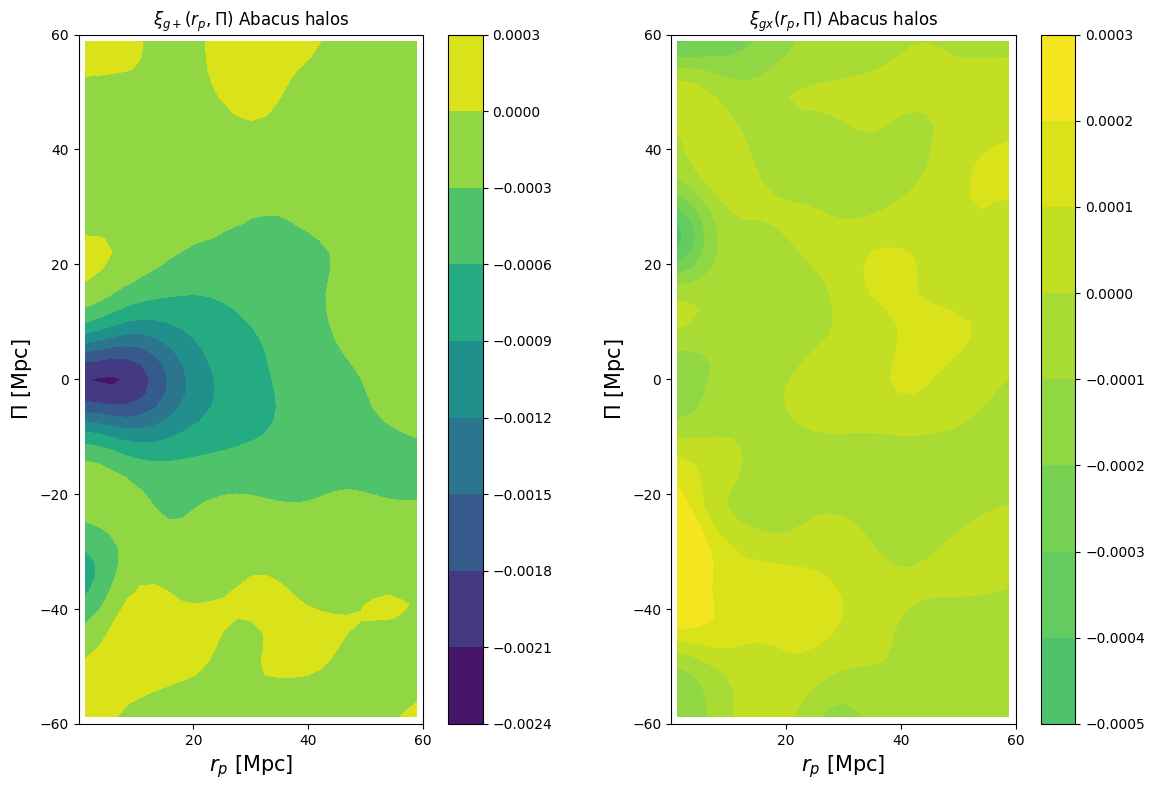

In [85]:
make_rsd_diagram(xi_gp_halos_tc.T, xi_gc_halos_tc.T, rmin=60, sigma=2, contourf=True, vmin=-0.0024, vmax=0.0003, log=False, title_p=r'$\xi_{g+}(r_p,\Pi)$ Abacus halos', title_x=r'$\xi_{gx}(r_p,\Pi)$ Abacus halos')

### Computing $w_{g+}$ and $w_{g\times}$

$w_{g+}(r_p) = \int_{-\Pi_{max}}^{\Pi_{max}}d\Pi~\xi_{g+}(r_p,\Pi)$

$w_{g\times}(r_p) = \int_{-\Pi_{max}}^{\Pi_{max}}d\Pi~\xi_{g\times}(r_p,\Pi)$

In [86]:
def compute_halo_intrinsic_alignments (x_val, y_val, z_val, e1, e2, nrp=25, npi=50, npatch=20):
    
    halo_shapes = treecorr.Catalog(x=x_val, y=y_val, z=z_val, g1=e1, g2=e2, npatch=npatch)

    pi = np.linspace(-15, 15, npi)

    xi_gp = [] ; xi_gp = list(xi_gp) ; xi_gc = [] ; xi_gc = list(xi_gc)
    var = [] ; var = list(var) ; rp = [] ; rp = list(rp)

    for i in np.arange(0, npi-1):

        ng = treecorr.NGCorrelation(nbins=nrp, 
                                min_sep = 0.1,
                                max_sep = 200.,
                                min_rpar = pi[i],
                                max_rpar = pi[i+1],
                                bin_type='Log',
                                bin_slop=0.1,
                                angle_slop=0.1,
                                var_method='jackknife',
                                cross_patch_weight='simple')
        ng.process(halo_shapes, halo_shapes, metric ='Rperp')

        xi_p, xi_c, var2 = ng.calculateXi(rg=None) ; r=ng.logr

        xi_gp.append(xi_p) ; xi_gc.append(xi_c) ; var.append(var2) ; rp.append(r)

    xi_gp_halos_tc=np.array(xi_gp) ; xi_gc_halos_tc=np.array(xi_gc) ; var_halos_tc = np.array(var) ; r_halos_tc = np.array(rp)

    return xi_gp_halos_tc, xi_gc_halos_tc, var_halos_tc, r_halos_tc


xi_gp_halos_tc, xi_gc_halos_tc, var_halos_tc, r_halos_tc = compute_halo_intrinsic_alignments (x_val, y_val, z_val, e1_halos, e2_halos, nrp=25, npi=50, npatch=20)




nrp=25

wgp_halos_tc = np.zeros(nrp) ; sum_var_gp_halos_tc=np.zeros(nrp)
wgc_halos_tc = np.zeros(nrp) ; sum_var_gc_halos_tc=np.zeros(nrp)

# Summing over bins of Pi to get the projected correlation functions w_g+ and w_gx
for i in range (nrp):
    wgp_halos_tc[i] = abs(np.sum(xi_gp_halos_tc[:,i])) ; sum_var_gp_halos_tc[i]= np.sum(var_halos_tc[:,i])
    wgc_halos_tc[i] = abs(np.sum(xi_gc_halos_tc[:,i])) ; sum_var_gc_halos_tc[i]= np.sum(var_halos_tc[:,i])


sigma_gp_halos_tc = np.sqrt(sum_var_gp_halos_tc)
sigma_gc_halos_tc = np.sqrt(sum_var_gc_halos_tc)

### Plotting $r_p\times w_{g+}$ and $r_p\times w_{g\times}$

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_57556/1715095471.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


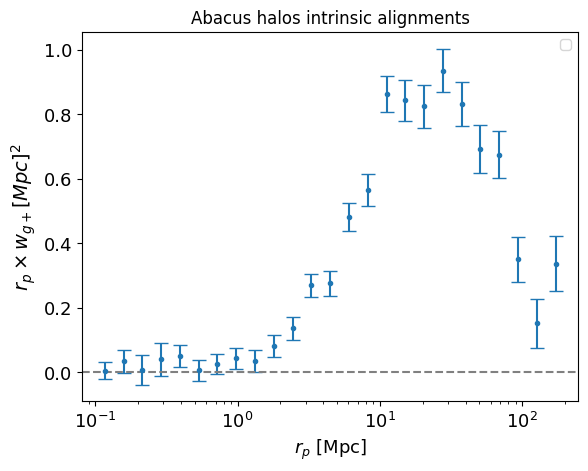

/var/folders/9q/xbftvbjx5px9w687wrb62dlh0000gn/T/ipykernel_57556/1715095471.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


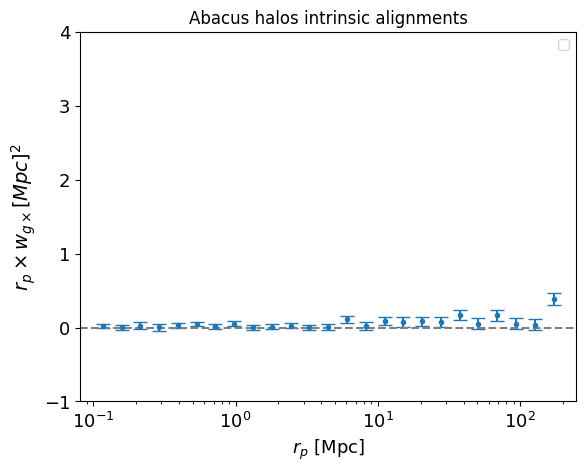

In [91]:
plt.errorbar(np.exp(r_halos_tc[0,:]), np.exp(r_halos_tc[0,:])*wgp_halos_tc, yerr= np.exp(r_halos_tc[0,:])*sigma_gp_halos_tc, fmt='o', markersize=3, capsize=5)
plt.xscale('log')
plt.xlabel(r'$r_p$ [Mpc]', fontsize=13)
plt.ylabel(r'$r_p \times w_{g+} [Mpc]^2$', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("Abacus halos intrinsic alignments")
plt.show()



plt.errorbar(np.exp(r_halos_tc[0,:]), np.exp(r_halos_tc[0,:])*wgc_halos_tc, yerr= np.exp(r_halos_tc[0,:])*sigma_gc_halos_tc, fmt='o', markersize=3, capsize=5)
plt.xscale('log')
plt.xlabel(r'$r_p$ [Mpc]', fontsize=13)
plt.ylabel(r'$r_p \times w_{g\times} [Mpc]^2$', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.ylim(-1,4)
plt.legend()
plt.axhline(0, color='grey', linestyle='--')
plt.title("Abacus halos intrinsic alignments")
plt.show()